In [ ]:
pip install numpy pandas yfinance matplotlib scikit-learn tensorflow keras-tuner

[*********************100%***********************]  1 of 1 completed

Epoch 1/120



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 - 1s - 1s/step - loss: 0.0445 - val_loss: 0.0204
Epoch 2/120
1/1 - 0s - 181ms/step - loss: 0.0048 - val_loss: 1.3803e-04
Epoch 3/120
1/1 - 0s - 60ms/step - loss: 0.0086 - val_loss: 0.0023
Epoch 4/120
1/1 - 0s - 63ms/step - loss: 0.0166 - val_loss: 0.0017
Epoch 5/120
1/1 - 0s - 59ms/step - loss: 0.0133 - val_loss: 3.3573e-06
Epoch 6/120
1/1 - 0s - 58ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 7/120
1/1 - 0s - 170ms/step - loss: 0.0010 - val_loss: 0.0114
Epoch 8/120
1/1 - 0s - 121ms/step - loss: 0.0025 - val_loss: 0.0197
Epoch 9/120
1/1 - 0s - 98ms/step - loss: 0.0062 - val_loss: 0.0226
Epoch 10/120
1/1 - 0s - 121ms/step - loss: 0.0078 - val_loss: 0.0193
Epoch 11/120
1/1 - 0s - 101ms/step - loss: 0.0061 - val_loss: 0.0127
Epoch 12/120
1/1 - 0s - 123ms/step - loss: 0.0030 - val_loss: 0.0062
Epoch 13/120
1/1 - 0s - 99ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 14/120
1/1 - 0s - 95ms/step - loss: 0.0012 - val_loss: 3.4526e-04
Epoch 15/120
1/1 - 0s - 130ms/step - loss: 0.0027 - v

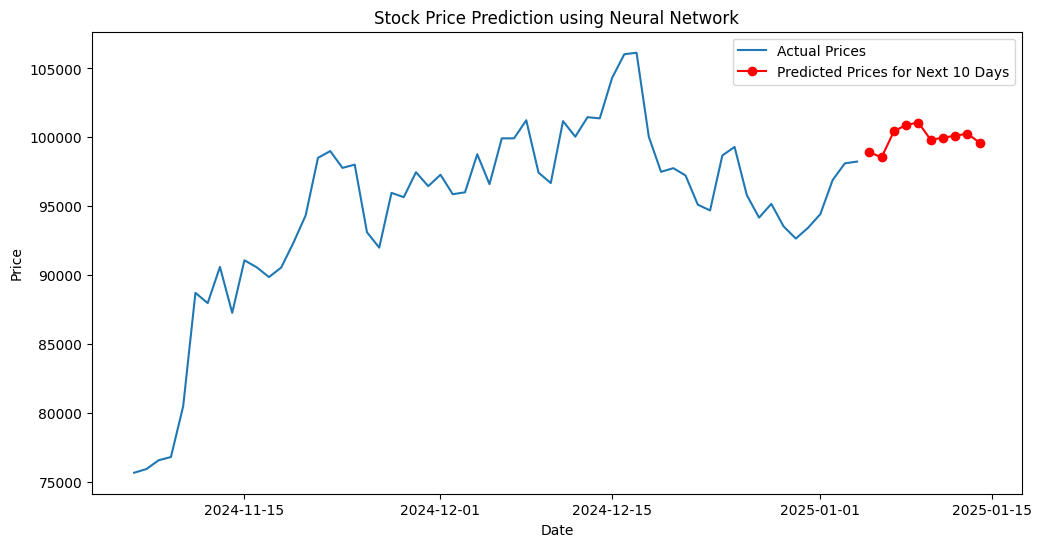

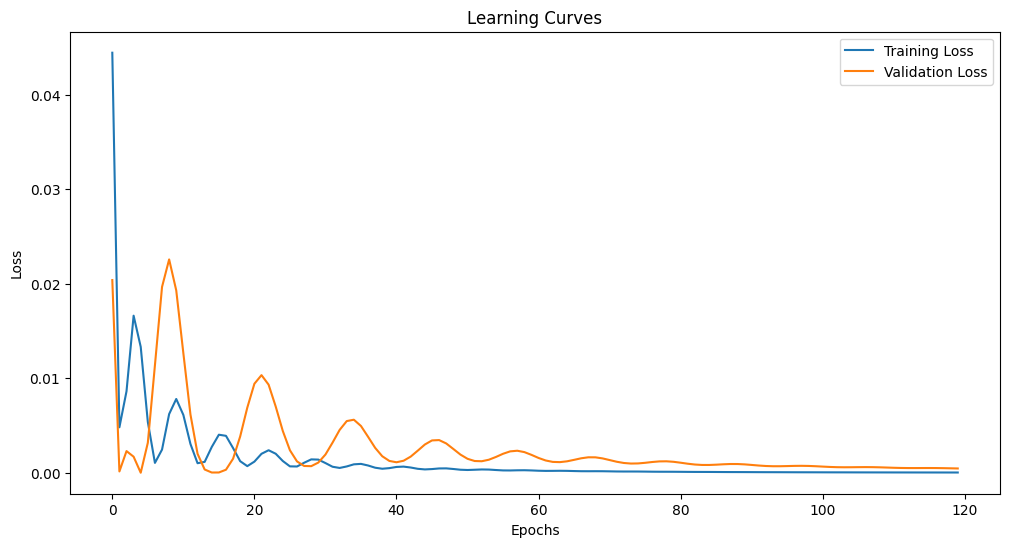

In [56]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from datetime import datetime, timedelta

# Fetch historical stock data
ticker = "BTC-USD"  # You can change this to any ticker symbol you want
data = yf.download(ticker, start="2024-11-01", end=datetime.now().strftime('%Y-%m-%d'))

# Use the 'Adj Close' column for predictions
df = data[['Adj Close']].rename(columns={'Adj Close': 'Price'})

# Ensure 'Date' column is of datetime type
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Create sequences for training the Neural Network
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # Sequence length
x, y = create_sequences(scaled_data, seq_length)

x_train, y_train = x[:-1], y[:-1]  # Use all but the last sequence for training
x_test = x[-1:]  # The last sequence will be used to predict the next day's price

# Reshape data for Neural Network (flatten the sequences)
x_train = x_train.reshape(x_train.shape[0], -1)  # Flatten sequences
x_test = x_test.reshape(x_test.shape[0], -1)  # Flatten sequences

# Build the Neural Network model
model = Sequential()
model.add(Dense(units=50, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))  # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, epochs=120, batch_size=32, verbose=2, validation_split=0.2)

# Predict the next 10 days' prices
predicted_prices = []
current_seq = x_test

for _ in range(10):
    # Predict the next day's price
    predicted_price_scaled = model.predict(current_seq)

    # Inverse transform the predicted price to get the actual price
    predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))[0][0]
    predicted_prices.append(predicted_price)

    # Update the current sequence to include the latest prediction
    new_seq = np.append(current_seq[:, 1:], predicted_price_scaled).reshape(1, -1)
    current_seq = new_seq

# Generate dates for the next 10 days
last_date = df.index[-1]
prediction_dates = [last_date + timedelta(days=i) for i in range(1, 11)]

# Print the predicted prices with dates
for date, price in zip(prediction_dates, predicted_prices):
    print(f"Date: {date.strftime('%Y-%m-%d')}, Predicted Price: {price:.2f}")

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df.index[-seq_length:], df['Price'].values[-seq_length:], label="Actual Prices")
plt.plot(prediction_dates, predicted_prices, 'ro-', label="Predicted Prices for Next 10 Days")
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
